# Biodiversity Intactness Index Changes in Phoenix, AZ, USA (2017-2020).

Author: Sofia Ingersoll

## Objective

Our goal with this project is to access the variations in biodiversity in Phoenix, Arizona between 2017 and 2020 to determine the affects of urban development. The metropolitan area of Phoenix, more specifically, Maricopa County, was dubbed the most developed land since 2001, in 2021 [1]. As the sprawl of the urban landscape continues to grow, new pressures are introduced to natural areas, creating stress on local biodiversity. Moinitoring the changes that evolve as a result of these changes is important for understanding anthropogenic activity impacts the natural environment. The assessments made using BII data may be applied strategically to spatial planning and management of remaining habitats.

### Method Highlights

- Accessing MPC STAC catalog collection for a specific bounding box
- Creating a map to demonstrate Phoenix subdivision 
- Calculating `pct_area` within Phoenix subdivision for 2017 & 2020
- Visualizing devestated BII areas (>= 75% lost) between 2017 and 2020

## About the Data

Two data sources are utilized in this document:

1. Microsoft Planetary Computer (MPC): Biodiversity Intactness

`io-biodiversity`

[https://planetarycomputer.microsoft.com/dataset/io-biodiversity]
 

2. TIGER Shapefiles Census County Subdivision shapefile for Arizona, specifically the Phoenix subdivision polygon.
[https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions] 

## Final Outputs

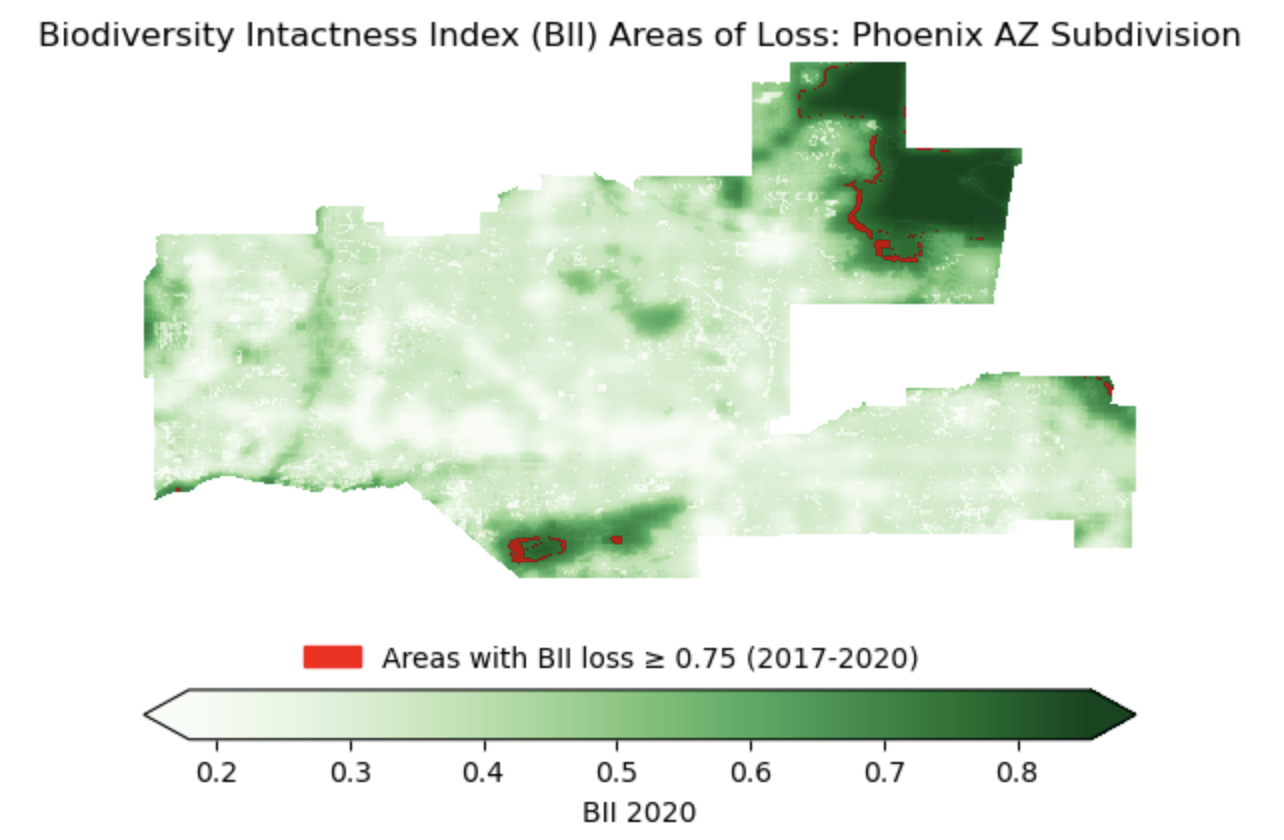


### Import Libraries

In [1]:
# loading libraries and functions
import pandas as pd
import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import contextily
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches       
import os 

from shapely.geometry import Polygon

from pystac_client import Client            # to access MPC STAC catalogs

import planetary_computer                   # access items from the MPC STAC catalog

from IPython.display import Image           # pretty display

### Access MCP STAC `io-biodiversity`

We will access the catalog and collection of interest for our region (bbox) and temporal range of interest (2017:2020). These STAC collections will be stored as an as a search `items`

In [2]:
# access catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# access the io-biodiversity collection
io_biodiversity_collection = catalog.get_child('io-biodiversity')
io_biodiversity_collection

# temporal range of interest
temporal_roi = "2017-01-01/2020-01-01"

# spatial region of interest
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# searching catalog for data of interest
search = catalog.search(collections=['io-biodiversity'],
                        bbox = bbox,
                        datetime = temporal_roi)

# storing search items as an object, we expect it to contain 4 items
items = search.item_collection()
len(items)

# look at items, are they what we expect?
#items

4

#### Selecting an Item from the `ItemCollection`

In [3]:
# subsetting for BII 2017 data 
BII_2017 = items[3]

# subsetting for BII 2020 data 
BII_2020 = items[0]

In [4]:
# hey assets, where is data stored?
for key in BII_2017.assets.keys():
    print(key, '--', BII_2017.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


##### Inspecting the properties of the item just read in
Below, we learn that the projection is EPSG:4326

In [5]:
# print item id and properties for BII 2017 
print('id:' , BII_2017.id)

BII_2017.properties

id: bii_2017_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2017-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2017-01-01T00:00:00Z'}

In [6]:
# load BII 2017 & 2020 data
BII_2017_data = rioxr.open_rasterio(BII_2017.assets['data'].href)

BII_2020_data = rioxr.open_rasterio(BII_2020.assets['data'].href)

#### Inspecting the MPC STAC Data

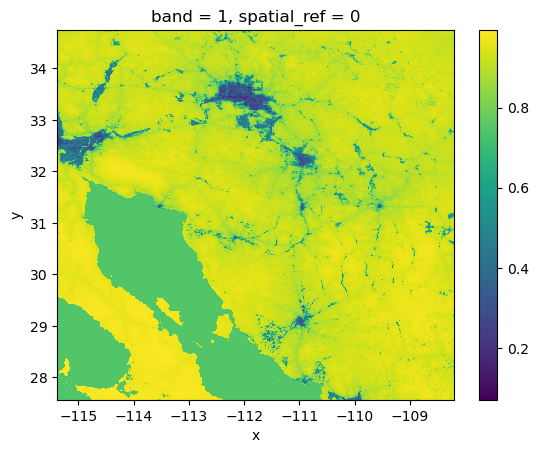

In [7]:
# quick visualization
BII_2017_data.plot()

In [ ]:
# quick visualization
BII_2020_data.plot()

### Load Shapefile of AZ

In [ ]:
# reading in .shp data using geopandas
arizona = gpd.read_file(os.path.join(os.getcwd(), 'tl_2022_04_cousub.shp'))

# create a subset of Phoenix, AZ
phoenix_polygon = arizona[arizona.NAME == 'Phoenix']

# projecting the crs to match biodiversity intactness index
phoenix_polygon = phoenix_polygon.to_crs(BII_2017_data.rio.crs)

# confirm the polygon contains Phoenix, AZ subdivision
phoenix_polygon.plot(color = 'hotpink')

### Clipping Items to Phoenix Polygon 

In [ ]:
# clip 2017 & 2020 BII rasters to geometry of phoenix polygon subdivision
BII_2017_phoenix = BII_2017_data.rio.clip(phoenix_polygon['geometry'])

BII_2020_phoenix = BII_2020_data.rio.clip(phoenix_polygon['geometry'])

In [ ]:
# Visualizing
BII_2017_phoenix.plot()

In [ ]:
# Visualizing
BII_2020_phoenix.plot()

### Calculating Percentage of Area in Phoenix, AZ with at least 75% BII (2017 & 2020)

In [ ]:
# Calculate the pct of area in 2017 Phoenix with a BII of at least 0.75

# Making a boolean xarray.DataArray based on BII condition
bool_2017 = BII_2017_phoenix >= 0.75
bool_2017.head

# Convert boolean vals. to 1 and 0
int_2017 = bool_2017.astype('int')
int_2017.head

# Calculate number of pixels that have a BII >= 0.75
pixels_2017 = int_2017.values.sum()

# Calculate total number of pixels for 2017
total_pixels_2017 = int_2017.rio.width * int_2017.rio.height

# Calculate percentage
pct_2017=(pixels_2017/total_pixels_2017)*100
print(f'The percentage of area in Phoenix subdivision with a BII of at least 0.75 in 2017:' , pct_2017)

# Making a boolean xarray.DataArray based on BII condition
bool_2020 = BII_2020_phoenix >= 0.75

# Convert boolean vals. to 1 and 0
int_2020 = bool_2020.astype('int')
int_2020.head()

# Calculate number of pixels that have a BII >= 0.75
pixels_2020 = int_2020.values.sum()

# Calculate total number of pixels for 2020
total_pixels_2020 = int_2020.rio.width * int_2020.rio.height

# Calculate percentage
pct_2020=(pixels_2020/total_pixels_2020)*100
print(f'The percentage of area in Phoenix subdivision with a BII of at least 0.75 in 2020:' , pct_2020)

### Areas of Biodiversity Intactness Index Reduction >= 75% (2017:2020)

Next, we will identify the areas within the Phoenix subdivision that experienced a loss in BII of at least 75% between 2017 and 2020. In order to do this, we will need to make a raster that contains these specific areas within the region to explore further. 

In [ ]:
# Identify areas that the BII changed between 2017 and 2020
area_of_loss = int_2017 - int_2020

# All values not equal to 1, make NA
aol = area_of_loss.where(area_of_loss == 1)

### Visualizing Areas of BII Loss

Below we will visualize the areas that experienced a biodiversity intactness index loss of at least 75% within the Phoenix Arizona subdivision between 2017 and 2020.

In [ ]:
# initializing plot
fig, ax = plt.subplots()

ax.axis('off')                                                     # remove axis

phoenix_polygon.boundary.plot( ax = ax,
                              color = 'black',
                              linewidth = 1)



BII_2020_phoenix.plot(ax = ax,                                     # 2020 BII pct map 
                      cmap = 'Greens',
                      robust = True,
                      cbar_kwargs={'orientation':'horizontal',
                                       'label':'BII 2020'})

aol.plot(ax = ax,
         cmap = 'gist_heat',
         add_colorbar = False)

# add legend item for areas with BII loss ≥ 0.75 from 2017
areas_of_loss = mpatches.Patch(color = 'red',
                               label = 'Areas with BII loss ≥ 0.75 (2017-2020)')
# add title
ax.set_title("Biodiversity Intactness Index (BII) Areas of Loss: Phoenix AZ Subdivision")

# add legend handle 
ax.legend(handles = [areas_of_loss],
          frameon = False,
          loc = (0.15, -0.2))

plt.show()                                                        # show me the plot baby

# saving plot as image
fig.savefig('BII_aol_phoenix.png')

Publication Date: 13 December 2023.